# CSE547 -  Project Data Preprocessing

### Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir("/content/drive/MyDrive/CSE 547 PROJECT/data")
!ls

2DAXT2.csv	  2DAXT2_normalized.csv  clinical_data.xlsx  data.npz	   ReMIND
2DAXT2_label.csv  class_mapper.csv	 data.csv	     metadata.csv


### Data Structure

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
metadata = pd.read_csv("metadata.csv")
metadata.columns

Index(['Series UID', 'Collection', '3rd Party Analysis',
       'Data Description URI', 'Subject ID', 'Study UID', 'Study Description',
       'Study Date', 'Series Description', 'Manufacturer', 'Modality',
       'SOP Class Name', 'SOP Class UID', 'Number of Images', 'File Size',
       'File Location', 'Download Timestamp'],
      dtype='object')

In [ ]:
metadata.groupby(['Study Description'])['Number of Images'].sum()

Study Description
Intraop    37558
Preop      48175
Name: Number of Images, dtype: int64

In [ ]:
metadata.groupby(['Modality'])['Number of Images'].sum()

Modality
MR     85057
SEG      356
US       320
Name: Number of Images, dtype: int64

In [ ]:
metadata.groupby(['Modality', 'Study Description'])['Number of Images'].sum()

Modality  Study Description
MR        Intraop              37176
          Preop                47881
SEG       Intraop                 62
          Preop                  294
US        Intraop                320
Name: Number of Images, dtype: int64

### MRIs
Consider only 2D slices of MRIs for now.

In [ ]:
mr_metadata = metadata[metadata['Modality'] == 'MR']

In [ ]:
mr_metadata.groupby(['Study Description', 'Series Description'])['Number of Images'].sum()

Study Description  Series Description 
Intraop            2DAXT2                    40
                   2DAXT2BLADE             7451
                   2DAXT2FLAIR             1486
                   2DCORT2BLADE            1107
                   2DCORT2FLAIR             148
                   2DSAGT2BLADE             210
                   3DAXT1MP2RAGE            386
                   3DAXT1postcontrast     11137
                   3DAXT1precontrast       3344
                   3DAXT2SPACE              704
                   3DSAGT1MP2RAGE          1056
                   3DSAGT2FLAIR            9845
                   3DSAGT2SPACE             192
                   AXT2BLADE                 70
Preop              2DAXT2                  1230
                   2DAXT2BLADE             1671
                   2DAXT2FLAIR             2223
                   2DCORT2BLADE            1897
                   2DCORT2FLAIR             234
                   2DSAGT2BLADE             121
 

*ReMIND* contains 369 preoperative MRI
series, 320 3D intraoperative ultrasound series, 301 intraoperative MRI series, and 356 segmentations collected from 114
consecutive patients at a single institution.

The MRI has several sequences, which can express tumor structure in different ways.

*Preoperative MRI*:
- native T1-weighted (T1)
- contrast-enhanced T1-weighted (ceT1)
- native T2-weighted (T2)
- T2-weighted fluid-attenuated inversion recovery (T2-FLAIR).

*intraoperative MRI*:
all intraoperative MRI were acquired using a 3T wide-bore (70 cm) MRI scanner

In [ ]:
mr_pre = mr_metadata[mr_metadata['Study Description'] == 'Preop']
mr_intra = mr_metadata[mr_metadata['Study Description'] == 'Intraop']

In [ ]:
mr_pre_dirs = mr_pre.groupby('Series Description')['File Location'].apply(list)
mr_pre_dirs

Series Description
2DAXT2                 [.\ReMIND\ReMIND-007\12-25-1982-NA-Preop-57336...
2DAXT2BLADE            [.\ReMIND\ReMIND-003\12-25-1982-NA-Preop-14674...
2DAXT2FLAIR            [.\ReMIND\ReMIND-008\12-25-1982-NA-Preop-97438...
2DCORT2BLADE           [.\ReMIND\ReMIND-001\12-25-1982-NA-Preop-56579...
2DCORT2FLAIR           [.\ReMIND\ReMIND-010\12-25-1982-NA-Preop-40071...
2DSAGT2BLADE           [.\ReMIND\ReMIND-051\12-25-1982-NA-Preop-21813...
2DSAGT2FLAIR           [.\ReMIND\ReMIND-049\12-25-1982-NA-Preop-10408...
3DAXT1MP2RAGE          [.\ReMIND\ReMIND-013\12-25-1982-NA-Preop-10946...
3DAXT1postcontrast     [.\ReMIND\ReMIND-001\12-25-1982-NA-Preop-56579...
3DAXT1precontrast      [.\ReMIND\ReMIND-005\12-25-1982-NA-Preop-69356...
3DAXT2                 [.\ReMIND\ReMIND-033\12-25-1982-NA-Preop-81621...
3DAXT2FLAIR            [.\ReMIND\ReMIND-087\12-25-1982-NA-Preop-23943...
3DAXT2SPACE            [.\ReMIND\ReMIND-002\12-25-1982-NA-Preop-78948...
3DCORT1postcontrast    [.\ReMIND

### Sample Visualizations

Explore differences in images among Series (MRI Sequence) group. Try to assign MRI sequence label based on Series Description.

In [ ]:
!pip install pydicom

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 10.6 MB/s eta 0:00:00


In [ ]:
import glob
import pydicom
import matplotlib.pyplot as plt

In [ ]:
def read_images(folder):
  dicom_files = glob.glob(folder+'/*.dcm')
  if not dicom_files:
      raise FileNotFoundError(f"No DICOM files in {folder}")
  return [pydicom.dcmread(im) for im in dicom_files]

#### 2DAXT2

In [ ]:
single_sample = []
for folder in mr_pre_dirs['2DAXT2']:
  single_sample+= read_images(folder.replace('\\','/'))

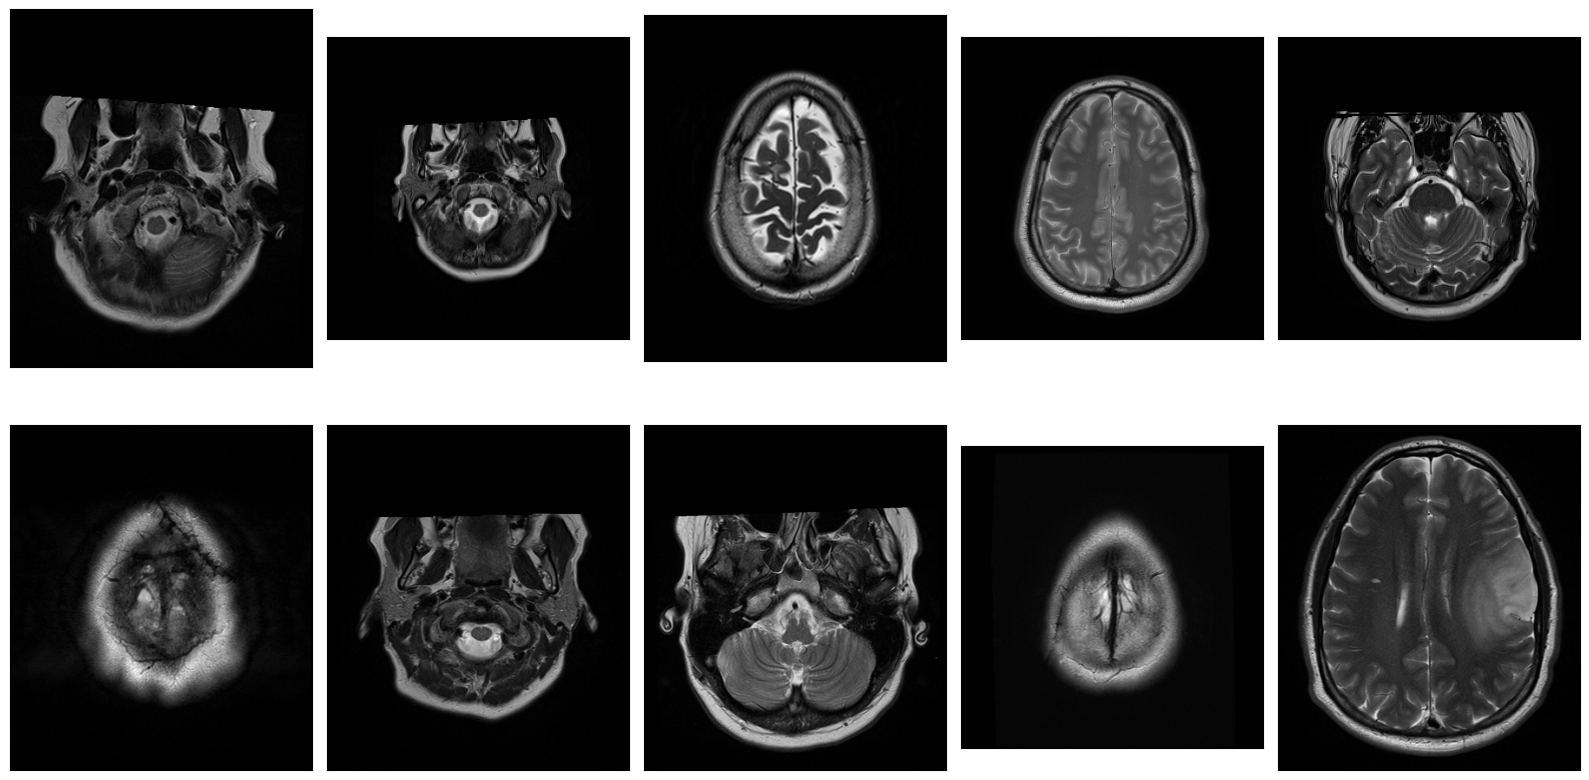

In [ ]:
plt.subplots(2,5, figsize=(16,9))
for i in range(10):
  plt.subplot(2,5,i+1)
  im = single_sample[i*120].pixel_array
  plt.imshow(im, cmap='gray')
plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])
plt.tight_layout()
plt.show()

#### 2DAXT2 vs 3DAXT2 vs 3DSAGT2

2D ≈ 3D

AX != SAG

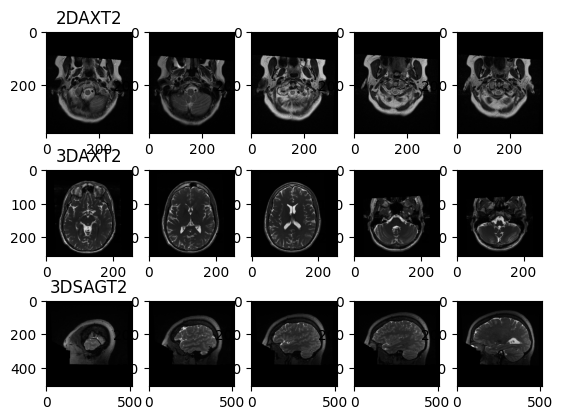

In [ ]:
# 2DAXT2 vs 3DAXT2 vs 3DSAGT2
sample1 = [mr_pre_dirs['2DAXT2'][0], mr_pre_dirs['3DAXT2'][0], mr_pre_dirs['3DSAGT2'][0]]
sample1_mris = []
for folder in sample1:
  sample1_mris.append(read_images(folder.replace('\\','/')))
fig, axs = plt.subplots(3,5)
axs[0, 0].set_title('2DAXT2')
axs[1, 0].set_title('3DAXT2')
axs[2, 0].set_title('3DSAGT2')
for j in range(5):
  im = sample1_mris[0][j].pixel_array
  axs[0, j].imshow(im, cmap='gray')
for j in range(5):
  im = sample1_mris[1][50+j*6].pixel_array
  axs[1, j].imshow(im, cmap='gray')
for j in range(5):
  im = sample1_mris[2][60+j*12].pixel_array
  axs[2, j].imshow(im, cmap='gray')
plt.show()

#### 2DAXT2 vs 2DAXT2BLADE vs 2DAXT2FLAIR vs 2DCORT2BLADE vs 2DCORT2FLAIR vs 2DSAGT2BLADE vs 2DSAGT2FLAIR

In [ ]:
# 2DAXT2 vs 2DAXT2BLADE vs 2DAXT2FLAIR vs 2DCORT2BLADE vs 2DCORT2FLAIR vs 2DSAGT2BLADE vs 2DSAGT2FLAIR
sample2 = [mr_pre_dirs['2DAXT2'][0], \
           mr_pre_dirs['2DAXT2BLADE'][0], mr_pre_dirs['2DAXT2FLAIR'][0], \
           mr_pre_dirs['2DCORT2BLADE'][0], mr_pre_dirs['2DCORT2FLAIR'][0], \
           mr_pre_dirs['2DSAGT2BLADE'][0], mr_pre_dirs['2DSAGT2FLAIR'][0]]
sample2_mris = []
for folder in sample2:
  sample2_mris.append(read_images(folder.replace('\\','/')))

In [ ]:
fig, axs = plt.subplots(7,5, figsize=(35,35))
axs[0, 0].set_title('2DAXT2')
axs[1, 0].set_title('2DAXT2BLADE')
axs[2, 0].set_title('2DAXT2FLAIR')
axs[3, 0].set_title('2DCORT2BLADE')
axs[4, 0].set_title('2DCORT2FLAIR')
axs[5, 0].set_title('2DSAGT2BLADE')
axs[6, 0].set_title('2DSAGT2FLAIR')
for j in range(5):
  im = sample2_mris[0][j].pixel_array
  axs[0, j].imshow(im, cmap='gray')
for j in range(5):
  im = sample2_mris[1][4+j].pixel_array
  axs[1, j].imshow(im, cmap='gray')
for j in range(5):
  im = sample2_mris[2][3+j].pixel_array
  axs[2, j].imshow(im, cmap='gray')
for j in range(5):
  im = sample2_mris[3][1+2*j].pixel_array
  axs[3, j].imshow(im, cmap='gray')
for j in range(5):
  im = sample2_mris[4][j*4].pixel_array
  axs[4, j].imshow(im, cmap='gray')
for j in range(5):
  im = sample2_mris[5][j*2].pixel_array
  axs[5, j].imshow(im, cmap='gray')
for j in range(5):
  im = sample2_mris[6][j*2].pixel_array
  axs[6, j].imshow(im, cmap='gray')
plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])
plt.show()

Output hidden; open in https://colab.research.google.com to view.

#### Split Dataset

- pre
                   2DAXT2                  1230
                   2DAXT2BLADE             1671
                   2DAXT2FLAIR             2223
                   2DCORT2BLADE            1897
                   2DCORT2FLAIR             234
                   2DSAGT2BLADE             121
                   2DSAGT2FLAIR             109
                   3DAXT1MP2RAGE            504
                   3DAXT1postcontrast     19930
                   3DAXT1precontrast        956
                   3DAXT2                   412
                   3DAXT2FLAIR              994
                   3DAXT2SPACE            12306
                   3DCORT1postcontrast      210
                   3DCORT2FLAIR             200
                   3DSAGT1MP2RAGE          1072
                   3DSAGT1postcontrast      276
                   3DSAGT2                  496
                   3DSAGT2FLAIR            2080
                   3DSAGT2SPACE             960
- intra
                   2DAXT2                    40
                   2DAXT2BLADE             7451
                   2DAXT2FLAIR             1486
                   2DCORT2BLADE            1107
                   2DCORT2FLAIR             148
                   2DSAGT2BLADE             210
                   3DAXT1MP2RAGE            386
                   3DAXT1postcontrast     11137
                   3DAXT1precontrast       3344
                   3DAXT2SPACE              704
                   3DSAGT1MP2RAGE          1056
                   3DSAGT2FLAIR            9845
                   3DSAGT2SPACE             192
                   AXT2BLADE                 70

In [ ]:
mr_intra_dirs = mr_intra.groupby('Series Description')['File Location'].apply(list)
mr_intra_dirs

Series Description
2DAXT2                [.\ReMIND\ReMIND-103\12-25-1982-NA-Intraop-695...
2DAXT2BLADE           [.\ReMIND\ReMIND-001\12-25-1982-NA-Intraop-904...
2DAXT2FLAIR           [.\ReMIND\ReMIND-001\12-25-1982-NA-Intraop-904...
2DCORT2BLADE          [.\ReMIND\ReMIND-015\12-25-1982-NA-Intraop-665...
2DCORT2FLAIR          [.\ReMIND\ReMIND-074\12-25-1982-NA-Intraop-633...
2DSAGT2BLADE          [.\ReMIND\ReMIND-002\12-25-1982-NA-Intraop-386...
3DAXT1MP2RAGE         [.\ReMIND\ReMIND-013\12-25-1982-NA-Intraop-603...
3DAXT1postcontrast    [.\ReMIND\ReMIND-002\12-25-1982-NA-Intraop-386...
3DAXT1precontrast     [.\ReMIND\ReMIND-001\12-25-1982-NA-Intraop-904...
3DAXT2SPACE           [.\ReMIND\ReMIND-005\12-25-1982-NA-Intraop-653...
3DSAGT1MP2RAGE        [.\ReMIND\ReMIND-012\12-25-1982-NA-Intraop-920...
3DSAGT2FLAIR          [.\ReMIND\ReMIND-003\12-25-1982-NA-Intraop-754...
3DSAGT2SPACE          [.\ReMIND\ReMIND-031\12-25-1982-NA-Intraop-748...
AXT2BLADE             [.\ReMIND\ReMIND-034\12

### Preprocessing

We will be using several preprocessing techniques on our images.

- Remove mostly black images.
- Crop images to reduce black areas.
- Remove mostly white images (probably skull).
- Resize images.
- Application of a denoising filter.

We will not apply image equalization as the different types of scans already have voluntary contrast variations.

In [ ]:
import cv2

In [ ]:
def is_mostly_black_image(image, threshold=0.15):
    non_black_pixel_count = np.count_nonzero(image>=11)
    non_black_proportion = non_black_pixel_count / image.size
    return non_black_proportion < threshold

In [ ]:
def remove_mostly_black_images(dicom_list, threshold=0.15):
    return [img for img in dicom_list if not is_mostly_black_image(img.pixel_array,threshold)]

In [ ]:
def crop_mostly_non_black_region(pixel_array, noise_threshold=0.5, dim=(256,256)):
    # Determine non-black rows and columns based on noise threshold
    non_black_rows = np.where(pixel_array.sum(axis=1) >= 11 * pixel_array.shape[1])[0]
    non_black_cols = np.where(pixel_array.sum(axis=0) >= 11 * pixel_array.shape[0])[0]

    # Check if any non-black region is detected
    if len(non_black_rows) == 0 or len(non_black_cols) == 0:
        return pixel_array  # Return original image if there's no non-black region

    # Crop to the mostly non-black region
    cropped_image = pixel_array[non_black_rows[0]:non_black_rows[-1] + 1,
                                non_black_cols[0]:non_black_cols[-1] + 1]

    # Resize
    cropped_image = cv2.resize(cropped_image, dim, interpolation = cv2.INTER_AREA)
    return cropped_image

#### 2DAXT2

In [ ]:
non_black_ax_t2 = remove_mostly_black_images(single_sample,0.2)
len(non_black_ax_t2)

1204

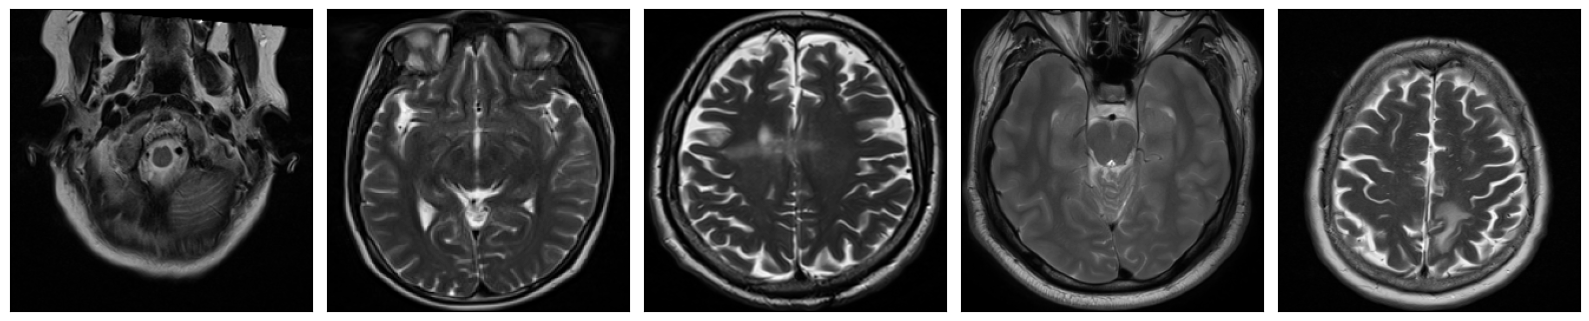

In [ ]:
ax_t2 = [crop_mostly_non_black_region(item.pixel_array) for item in non_black_ax_t2]
step = max(len(ax_t2)//10,1)
plt.subplots(1,5, figsize=(16,9))
for i in range(min(len(ax_t2),5)):
  plt.subplot(1,5,i+1)
  im = ax_t2[i*step]
  plt.imshow(im, cmap='gray')
plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])
plt.tight_layout()
plt.show()

In [ ]:
small_data = [im.reshape(256*256) for im in ax_t2]
len(small_data)

1204

In [ ]:
np.savetxt("2DAXT2.csv", small_data, delimiter = ",")

In [ ]:
class_mapper = pd.read_csv("class_mapper.csv")
ids = [str(item.PatientName)[-3:] for item in non_black_ax_t2]
dicom_dict = {
    'case': ids,
    'StudyDescription': [item.StudyDescription for item in non_black_ax_t2],
    'SeriesDescription': [item.SeriesDescription for item in non_black_ax_t2],
    'class': [class_mapper.iloc[int(id)-1]["Classes"] for id in ids]
}

df = pd.DataFrame(dicom_dict)
df.to_csv('2DAXT2_label.csv')

In [ ]:
from sklearn.preprocessing import normalize

small_data_normalized = normalize(np.array(small_data), axis=1)
np.savetxt("2DAXT2_normalized.csv", small_data_normalized, delimiter = ",")

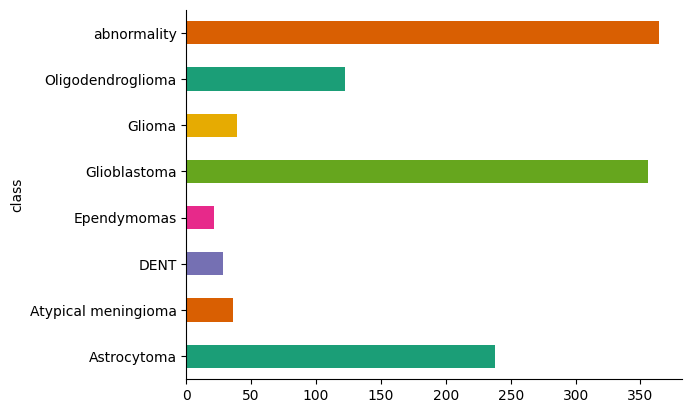

In [ ]:
# @title class

from matplotlib import pyplot as plt
import seaborn as sns
df.groupby('class').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

#### 3DAXT1precontrast, 3DAXT1postcontrast

In [ ]:
ax_t1_sample = []
for folder in mr_pre_dirs['3DAXT1precontrast']:
  ax_t1_sample += read_images(folder.replace('\\','/'))
len(ax_t1_sample)

956

In [ ]:
non_black_ax_t1 = remove_mostly_black_images([item.pixel_array for item in ax_t1_sample])
len(non_black_ax_t1)

AttributeError: 'numpy.ndarray' object has no attribute 'pixel_array'

In [ ]:
new_mris_ax_t1 = [crop_mostly_non_black_region(item) for item in non_black_ax_t1]
step = len(new_mris_ax_t1)//288
plt.subplots(48,6, figsize=(16,32))
for i in range(288):
  plt.subplot(48,6,i+1)
  im = new_mris_ax_t1[i*step]
  plt.imshow(im, cmap='gray')
plt.show()

In [ ]:
ax_cet1_sample = []
for folder in mr_pre_dirs['3DAXT1postcontrast']:
  ax_cet1_sample += read_images(folder.replace('\\','/'))
len(ax_cet1_sample)